# Description

This notobook simply demonstrades how to perform the Post-Traning-Quantization technique on the Cifar-10 dataset.

In [8]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import random
random.seed(42)
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try: tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:   print(e)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

from tensorflow.keras.layers import Layer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.utils import to_categorical

import sys
sys.path.append('../')
from utils.quantization_utils import *

# 1. Normal training

In [7]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

x_train, x_test = x_train / 255.0, x_test / 255.0

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [10]:
tf.keras.backend.clear_session()
model = Sequential([
    Input(shape=(32, 32, 3)),
    Flatten(), 
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')  # Output layer for 10 classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 128)               393344    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 394634 (1.51 MB)
Trainable params: 394634 (1.51 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
history = model.fit(x_train, y_train, epochs=20, batch_size=64, validation_data=(x_test, y_test))

y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

print()
accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)
print(f'Accuracy: {accuracy}')

Epoch 1/20
782/782 [==============================] - 1s 1ms/step - loss: 1.9178 - accuracy: 0.3187 - val_loss: 1.7930 - val_accuracy: 0.3632
Epoch 2/20
782/782 [==============================] - 1s 946us/step - loss: 1.7697 - accuracy: 0.3762 - val_loss: 1.7681 - val_accuracy: 0.3667
Epoch 3/20
782/782 [==============================] - 1s 953us/step - loss: 1.7031 - accuracy: 0.3956 - val_loss: 1.7520 - val_accuracy: 0.3688
Epoch 4/20
782/782 [==============================] - 1s 943us/step - loss: 1.6674 - accuracy: 0.4089 - val_loss: 1.6976 - val_accuracy: 0.4041
Epoch 5/20
782/782 [==============================] - 1s 959us/step - loss: 1.6330 - accuracy: 0.4232 - val_loss: 1.6673 - val_accuracy: 0.4100
Epoch 6/20
782/782 [==============================] - 1s 972us/step - loss: 1.6125 - accuracy: 0.4305 - val_loss: 1.6551 - val_accuracy: 0.4146
Epoch 7/20
782/782 [==============================] - 1s 1ms/step - loss: 1.5946 - accuracy: 0.4336 - val_loss: 1.5858 - val_accuracy: 0.4

# 2. Post-Training Quantization

In this section, we will implement the **asymmetric** quantization.

In [9]:
LIST_LABEL = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

x_train, x_test = x_train / 255.0, x_test / 255.0

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [ ]:
# Custom Dense Layer for asymmetric quantization
class CustomDense(Layer):
    def __init__(self, units, activation=None, quantized_type=tf.int8):
        super(CustomDense, self).__init__()
        self.units = units
        self.activation = tf.keras.activations.get(activation)
        self.quantized_type = quantized_type


    def build(self, input_shape):
        # Initialize weights and bias
        self.w = self.add_weight(shape=(input_shape[-1], self.units), initializer='random_normal', trainable=True)
        self.b = self.add_weight(shape=(self.units,), initializer='random_normal', trainable=True)

        self.w_quantized = self.add_weight(shape=(input_shape[-1], self.units), dtype=self.quantized_type, initializer='zeros', trainable=False)
        self.quantized_scale = self.add_weight(shape=(), initializer='ones', trainable=False)
        self.zero_point = self.add_weight(shape=(), initializer='ones', trainable=False)

        super(CustomDense, self).build(input_shape)  # Be sure to call this at the end


    def post_training_quantization(self):
        """
        Function to quantize the weights. This function MUST be called after FINISH training.
        """

        w_quantized, quantized_scale, zero_point = get_asymmetric_quantize_matrix(self.w, target_dtype=self.quantized_type)

        self.w_quantized.assign(w_quantized)
        self.quantized_scale.assign(quantized_scale)
        self.zero_point.assign(zero_point)

        del self.w

    def call(self, inputs):
        if hasattr(self, 'w'):  # Linear transformation
            z = tf.matmul(inputs, self.w) + self.b  
        else:
            # De-quantize the weights
            w_dequantized = tf.cast(self.w_quantized, tf.float32) - self.zero_point
            w_dequantized = tf.multiply(w_dequantized, self.quantized_scale)
            z = tf.matmul(inputs, w_dequantized) + self.b

        if self.activation:
            z = self.activation(z)  
        return z  
    

class Post_Quantization_Callback(tf.keras.callbacks.Callback):
    def __init__(self):
        super(Post_Quantization_Callback, self).__init__()

    def on_train_end(self, logs=None):
        self.quantization_layer()

    def quantization_layer(self):
        for layer in self.model.submodules:
            if isinstance(layer, CustomDense):
                layer.post_training_quantization()

In [11]:
tf.keras.backend.clear_session()
model_2 = Sequential([
    Input(shape=(32, 32, 3)),
    Flatten(),  
    CustomDense(128, activation='relu'),  
    CustomDense(10, activation='softmax') 
])

model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 custom_dense (CustomDense)  (None, 128)               786562    
                                                                 
 custom_dense_1 (CustomDens  (None, 10)                2572      
 e)                                                              
                                                                 
Total params: 789134 (1.88 MB)
Trainable params: 394634 (1.51 MB)
Non-trainable params: 394500 (385.27 KB)
_________________________________________________________________


In [12]:
model_2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [
    Post_Quantization_Callback()
]

model_2.fit(x_train, y_train, epochs=10, callbacks=callbacks)

Epoch 1/10
1563/1563 [==============================] - 2s 829us/step - loss: 1.8593 - accuracy: 0.3292
Epoch 2/10
1563/1563 [==============================] - 1s 784us/step - loss: 1.7091 - accuracy: 0.3883
Epoch 3/10
1563/1563 [==============================] - 1s 776us/step - loss: 1.6549 - accuracy: 0.4114
Epoch 4/10
1563/1563 [==============================] - 1s 768us/step - loss: 1.6150 - accuracy: 0.4223
Epoch 5/10
1563/1563 [==============================] - 1s 767us/step - loss: 1.5809 - accuracy: 0.4375
Epoch 6/10
1563/1563 [==============================] - 1s 783us/step - loss: 1.5618 - accuracy: 0.4421
Epoch 7/10
1563/1563 [==============================] - 1s 788us/step - loss: 1.5424 - accuracy: 0.4519
Epoch 8/10
1563/1563 [==============================] - 1s 791us/step - loss: 1.5249 - accuracy: 0.4560
Epoch 9/10
1563/1563 [==============================] - 1s 784us/step - loss: 1.5126 - accuracy: 0.4609
Epoch 10/10
1563/1563 [==============================] - 1s 762u

In [13]:
y_pred = model_2.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

print()
accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)
print(f'Accuracy: {accuracy}')

313/313 [==============================] - 0s 399us/step

Accuracy: 0.4466


1/1 [==============================] - 0s 8ms/step


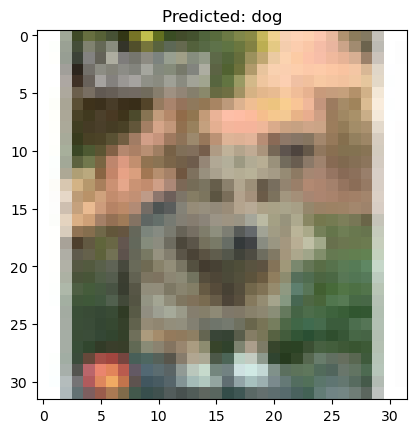

In [14]:
idx = np.random.randint(0, x_test.shape[0])
img = x_test[idx]
img = np.expand_dims(img, axis=0)
pred = model_2.predict(img)
pred = np.argmax(pred, axis=1)

pred_label = LIST_LABEL[pred[0]]

plt.imshow(x_test[idx])
plt.title(f'Predicted: {pred_label}');
